In [135]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

# from catboost import CatBoostRegressor

from sklearn.model_selection import TimeSeriesSplit

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

In [136]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.width', 1000)

In [137]:
# df = pd.read_csv("data/final_df.csv")
# df['date'] = pd.to_datetime(df['date'])

In [138]:
product = pd.read_csv('products.csv')
store = pd.read_csv('stores.csv')

store["store_id"] = store["store_id"].astype("object")
product["product_id"] = product["product_id"].astype("object")

store.drop_duplicates(inplace=True)
product.drop_duplicates(inplace=True)

In [139]:
def get_stats(X):
    X = eval(str(X))
    max_14 = np.max(X)
    min_14 = min(X)
    max_7 = max(X[7:])
    min_7 = min(X[7:])
    mean_14 = np.mean(X[:])
    mean_7 = np.mean(X[7:])
    mean_3 = np.mean(X[11:])
    std_14 = np.std(X)
    std_7 = np.std(X[7:])
    std_3 = np.std(X[11:])
    return pd.Series([max_14, min_14, max_7, min_7, mean_14, mean_7, mean_3, std_14, std_7, std_3], index=['max_14', 'min_14', 'max_7', 'min_7', 'mean_14', 'mean_7', 'mean_3', 'std_14', 'std_7', 'std_3'])


class Stats_translate(BaseEstimator, TransformerMixin):
    def __init__(self, base=np.exp(1)):
        BaseEstimator.__init__(self)
        TransformerMixin.__init__(self)
        self.base = base

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        Series_list = [get_stats(x) for x in X.sales]
        return pd.DataFrame(Series_list)



def transform_store_data(store_id):
    store_data = store[store["store_id"] == int(store_id)][['region', 'type']]
    return store_data


class Store_translate(BaseEstimator, TransformerMixin):

    def __init__(self, base=np.exp(1)):
        BaseEstimator.__init__(self)
        TransformerMixin.__init__(self)
        self.base = base

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        store_id = X.store_id
        df_list = [transform_store_data(i) for i in store_id]
        return pd.concat(df_list)


    
def transform_product_data(product_id):
    product_data = product[product["product_id"] == int(
        product_id)][["product_type", "manufacturer"]]
    return product_data


class Product_translate(BaseEstimator, TransformerMixin):
    def __init__(self, base=np.exp(1)):
        BaseEstimator.__init__(self)
        TransformerMixin.__init__(self)
        self.base = base

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        product_id = X.product_id
        df_list = [transform_product_data(i) for i in product_id]
        return pd.concat(df_list)

In [140]:
lst_product = [['полуфабрикаты и субпродукты', 'ветчина', 'сосиски', 'колбасы',
       'паштеты', 'рулеты', 'сар', 'сардельки', 'копчености'], ['галерея вкуса', 'ферма', 'виталюр', 'производство']]

lst_store = [['Minsk', 'Mogilev', 'Minsk_reg', 'Grodno', 'Vitebsk', 'Brest'],['supermarket', 'minimarket']]

In [152]:
product_ohe = OneHotEncoder(categories=lst_product).fit(product[["product_type", "manufacturer"]])
product_pipeline = Pipeline([
    ('translate_product', Product_translate()),
    ("ohe", product_ohe)
])


store_ohe = OneHotEncoder(categories=lst_store).fit(store[["region", "type"]])
store_pipeline = Pipeline([
    ('translate_store', Store_translate()),
    ("ohe", store_ohe)
])

translate_pipeline = Pipeline([
    ('translate', Stats_translate())
])

preprocessor = ColumnTransformer(
    transformers=[
      ('get_store', store_pipeline, ["store_id"]),
     ('get_product', product_pipeline, ["product_id"]),
        ('stats', translate_pipeline, ['sales']),
    ]
)

pipeline_prepare = Pipeline(
    steps=[
        ('preprocessing', preprocessor),
        ]
)



pipeline_RandomForestRegressor = Pipeline(
    steps=[
        ('preprocessing', preprocessor),
        ("model", RandomForestRegressor())
    ]
)


pipeline_Ridge = Pipeline(
    steps=[
        ('preprocessing', preprocessor),
        ('ss', StandardScaler()),
        ("model", Ridge())
    ]
)

pipeline_XGB = Pipeline(
    steps=[
        ('preprocessing', preprocessor),
        ("model", XGBRegressor())
    ]
)

pipeline_LGBM = Pipeline(
    steps=[
        ('preprocessing', preprocessor),
        ("model", LGBMRegressor())
    ]
)


In [145]:
df = pd.read_csv("Ядерный_чемоданчик_clear.csv")
df.drop(columns="Unnamed: 0", inplace=True)


INDEX = df.target >0
df = df[INDEX]
X = df.drop("target", axis = 1)
y = df["target"]


In [51]:
pipeline_RandomForestRegressor.fit(X.iloc[:50000], y.iloc[:50000])

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('get_store',
                                                  Pipeline(steps=[('translate_store',
                                                                   Store_translate()),
                                                                  ('ohe',
                                                                   OneHotEncoder(categories=[['Minsk',
                                                                                              'Mogilev',
                                                                                              'Minsk_reg',
                                                                                              'Grodno',
                                                                                              'Vitebsk',
                                                                                              'Brest'],
                            

In [56]:
import pickle
with open('model_RandomForestRegressor.pkl', 'wb') as f:
    pickle.dump(pipeline_RandomForestRegressor, f)

In [15]:
tscv = TimeSeriesSplit(n_splits = 4)

# metrics

## Ridge

In [153]:
a = cross_val_score(pipeline_Ridge, X.iloc[:1500], y[:1500], cv=tscv, scoring="neg_mean_absolute_percentage_error")

In [154]:
a.mean()

-0.8657447517317806

In [155]:
b = cross_val_score(pipeline_Ridge, X.iloc[:10000], y[:10000], cv=tscv, scoring="neg_mean_absolute_percentage_error")

In [156]:
b.mean()

-0.5962727093574294

In [132]:
b

array([-0.57484277, -0.61331976, -0.58614236, -0.60910566])

In [115]:
model = pipeline_Ridge.fit(X.iloc[:100000], y[:100000])


In [129]:
from sklearn.metrics import mean_absolute_percentage_error

In [125]:
y_pred = model.predict(X.iloc[100001:101001])

In [ ]:
mean_absolute_percentage_error

In [130]:
mean_absolute_percentage_error(y[100001:101001], y_pred)

0.7456241930310983

In [134]:
import pickle
with open('model_Ridge_100000.pkl', 'wb') as f:
    pickle.dump(model, f)

## XGB

In [16]:
XGB_1500 = cross_val_score(pipeline_XGB, X.iloc[:1500], y[:1500], cv=tscv, scoring="neg_mean_absolute_percentage_error")A

In [17]:
XGB_1500.mean()

-0.9000816047165957

In [25]:
XGB_25000 = cross_val_score(pipeline_XGB, X.iloc[:25000], y[:25000], cv=tscv, scoring="neg_mean_absolute_percentage_error")

In [26]:
XGB_25000.mean()

-0.6441018165543617

In [143]:
XGB_25000_load = cross_val_score(pipeline_XGB, X.iloc[:25000], y[:25000], cv=tscv, scoring="neg_mean_absolute_percentage_error")

In [144]:
XGB_25000_load.mean()

-0.6441018165543617

## traing to plot importance

In [91]:
pipeline_prepare.fit_transform(X.iloc[:100])

array([[1.        , 0.        , 0.        , ..., 1.11153922, 1.07269883,
        0.40988562],
       [1.        , 0.        , 0.        , ..., 7.71693076, 6.59931969,
        7.36357401],
       [1.        , 0.        , 0.        , ..., 0.70016711, 0.73579844,
        0.66219232],
       ...,
       [1.        , 0.        , 0.        , ..., 1.11803399, 1.2453997 ,
        0.47140452],
       [1.        , 0.        , 0.        , ..., 0.88352263, 0.9035079 ,
        0.47140452],
       [1.        , 0.        , 0.        , ..., 2.4453204 , 2.79941685,
        1.24721913]])

In [97]:
model_10000 = LGBMRegressor()
model_10000.fit(X.iloc[:10],y[:10])

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: date, sales

In [95]:
model_10000.plot_importance()

AttributeError: 'Pipeline' object has no attribute 'plot_importance'

In [80]:
from xgboost import plot_importance
fig1=plt.gcf()
plot_importance(model_10000)
plt.draw()

ValueError: tree must be Booster, XGBModel or dict instance

<Figure size 432x288 with 0 Axes>

## LGBM

In [146]:
LGBM_5000 = cross_val_score(pipeline_LGBM, X.iloc[:5000], y[:5000], cv=tscv, scoring="neg_mean_absolute_percentage_error")

In [147]:
LGBM_5000.mean()

-0.6588875795637728

In [47]:
LGBM_25000 = cross_val_score(pipeline_LGBM, X.iloc[:25000], y[:25000], cv=tscv, scoring="neg_mean_absolute_percentage_error")

In [48]:
LGBM_25000.mean()

-0.6366515509448767

## RandomForestRegressor

In [101]:
params = {"model__n_estimators": [100, 150, 200], "model__max_depth": [3,5,7]}
tscv = TimeSeriesSplit(n_splits = 4)
scoring = "neg_mean_absolute_percentage_error"

search = GridSearchCV(pipeline_RandomForestRegressor, param_grid=params, cv=tscv, scoring=scoring)

In [102]:
search.fit(X.iloc[:10000], y[:10000])

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('get_store',
                                                                         Pipeline(steps=[('translate_store',
                                                                                          Store_translate()),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(categories=[['Minsk',
                                                                                                                     'Mogilev',
                                                                                                                     'Minsk_reg',
                                                                    

In [104]:
search.best_score_

-0.6129210781930874

In [105]:
search.best_params_

{'model__max_depth': 7, 'model__n_estimators': 200}

### trash

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [ ]:
r2_score(y[120001:], y_pred)

0.6844294483436921

In [ ]:
mean_absolute_error(y[120001:], y_pred)

7.761556027871489

In [ ]:
mean_absolute_percentage_error(y[120001:] + 0.0005, y_pred)

1.2382627372541997

[Text(0, 0, 'Регион'),
 Text(1, 0, 'Тип магазина'),
 Text(2, 0, 'тип продукта'),
 Text(3, 0, 'производитель')]

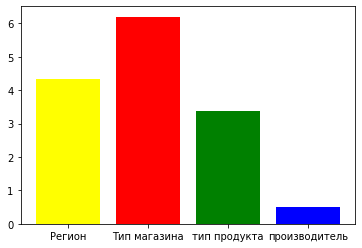

In [165]:
my_dict = {'Регион': [4.32771671], 'Тип магазина': [6.20173526], "тип продукта": [3.36497995], "производитель":  0.513122776}

fig, ax = plt.subplots()
ax.
ax.bar(my_dict.keys(),my_dict.values(), color=["yellow", "red", "green", "blue"])
ax.set_xticklabels(my_dict.keys())